# Quantum pipeline using the Quantum Trainer

### Read in the data and create diagrams

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from pytket.extensions.qiskit import AerBackend

from lambeq import NewCCGParser
from lambeq.core.types import AtomicType
from lambeq.circuit import IQPAnsatz



def accuracy(preds, targets):
    hits = 0
    for i in range(len(preds)):
        target = targets[i]
        pred = preds[i]
        if np.argmax(target) == np.argmax(pred):
            hits += 1
    return hits / len(preds)


BATCH_SIZE = 30
EPOCHS = 10
LEARNING_RATE = 3e-2
SEED = 0

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append(np.array([t, 1-t]))
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

reader = NewCCGParser()

raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)

### Remove the cups

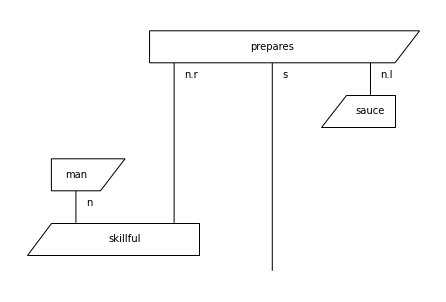

In [2]:
from discopy.rigid import Id

def remove_cups(diagram):
    # Remove cups to reduce post-selection in the circuit, for faster execution

    diags = []
    for box, offset in zip(diagram.boxes, diagram.offsets):
        if not box.dom:  # word box
            diags.insert(offset, box)
        else:  # cup (the only other type of box in these diagrams)
            i = 0
            off = offset
            while off != len(diags[i].cod) - 1:
                assert off > 0
                off -= len(diags[i].cod)
                i += 1
            left, right = diags[i:i+2]

            if len(left.cod) == 1:
                new_diag = right >> (left.r.dagger() @ Id(right.cod[1:]))
            else:
                assert len(right.cod) == 1
                new_diag = left >> (Id(left.cod[:-1]) @ right.l.dagger())

            diags[i:i+2] = [new_diag]

    assert len(diags) == 1
    return diags[0]


train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

### Create circuits

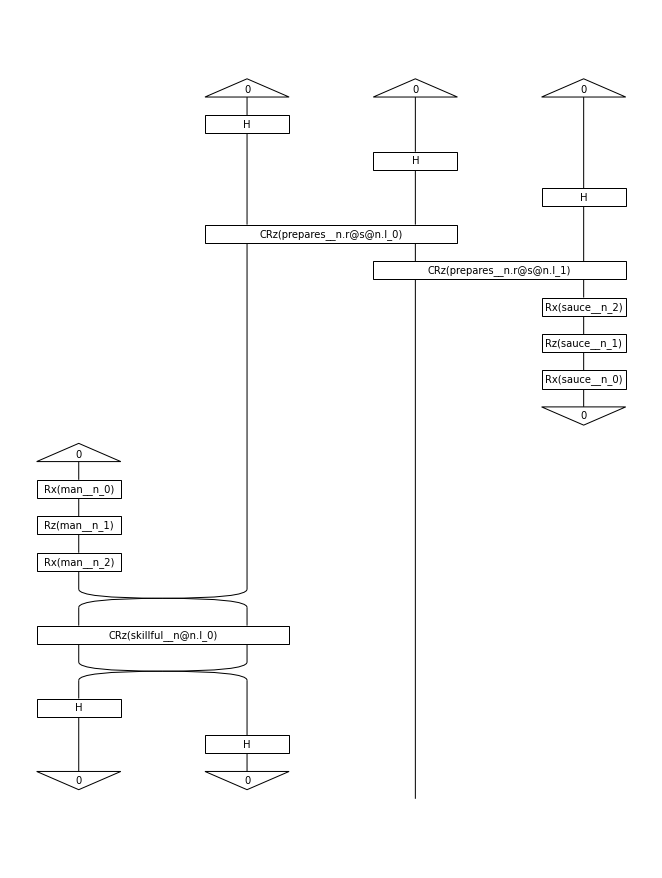

In [3]:
from lambeq.circuit import IQPAnsatz
from lambeq.core.types import AtomicType

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]
all_circuits = train_circuits+dev_circuits+test_circuits

train_circuits[0].draw(figsize=(9, 12))

### Initialise Quantum Model

In [4]:
from lambeq.training import TketModel

backend = AerBackend()

backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192  # maximum recommended shots, reduces sampling error
}

q_model = TketModel(all_circuits, backend_config, seed=SEED)
q_model.forward(train_circuits)

array([[0.70813397, 0.29186603],
       [0.33125   , 0.66875   ],
       [0.02027028, 0.97972972],
       ...,
       [0.04782609, 0.95217391],
       [0.37362638, 0.62637362],
       [0.27450981, 0.72549019]])

### Initialise NumpyModel

In [5]:
from lambeq.training import NumpyModel
from discopy import Tensor
import jax

Tensor.np = jax.numpy   # use jax support
np_model = NumpyModel(all_circuits, seed = 0)
np_model.forward(train_circuits)

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


array([[0.6300856 , 0.36991435],
       [0.4310039 , 0.56899613],
       [0.11484202, 0.88515794],
       ...,
       [0.21237172, 0.7876283 ],
       [0.4386683 , 0.5613317 ],
       [0.38067308, 0.6193269 ]], dtype=float32)

### Train

In [6]:
from lambeq.training import Dataset, QuantumTrainer, SPSAOptimiser

backend = AerBackend()

backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192  # maximum recommended shots, reduces sampling error
}

model = TketModel(all_circuits, backend_config, seed=SEED)

loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

EPOCHS = 120
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimiser,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    verbose = False,
    seed=0
)

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=30,
            shuffle=True,
            seed=0)

val_dataset = Dataset(dev_circuits, dev_labels)

trainer.fit(train_dataset, val_dataset)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Training successful!


### Show results

Test accuracy: 0.8333333333333334


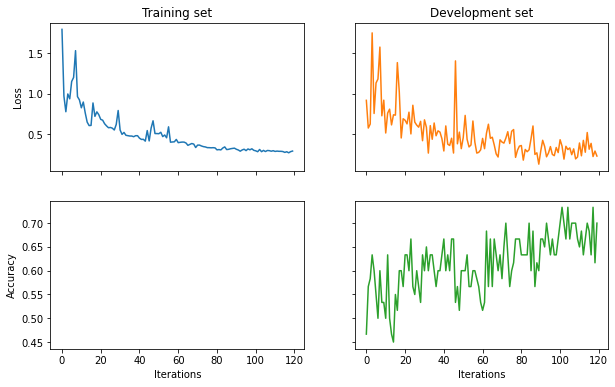

In [7]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))  # training evaluates twice per iteration
# ax_bl.plot(train_accs[1::2], color=next(colours))   # so take every other entry
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model.forward(test_circuits), test_labels)
print('Test accuracy:', test_acc)